# Library and Basic setting

In [1]:
import numpy as np

import torch
from torch.nn import functional as F
from torch import nn
import pytorch_lightning as pl

# default setting
np.set_printoptions(precision=2)
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=4)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(sci_mode=False)

In [2]:
import argparse
import sys
import os
import time
import pickle

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=135,
                    help='size of mini batch')
parser.add_argument('--learning_rate', type=float, default=0.02, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=.0001, help='decay rate for rmsprop')
parser.add_argument('--lamda_weights', type=float, default=.01, help='lamda weight')
parser.add_argument('--is_normalization', type=bool,
                    default=True, help='whether do data normalization')
parser.add_argument('--target_image_size', default=[300, 300], nargs=2, type=int,
                    help='Input images will be resized to this for data argumentation.')
parser.add_argument('--model_dir', type=str,
                    default='/notebooks/global_localization/lightning/baseline', help='rnn, gru, or lstm')
parser.add_argument('--test_dataset', type=str, default=['/notebooks/michigan_nn_data/2012_02_12',
                                                         '/notebooks/michigan_nn_data/2012_04_29',
                                                         '/notebooks/michigan_nn_data/2012_05_11',
                                                         '/notebooks/michigan_nn_data/2012_06_15',
                                                         '/notebooks/michigan_nn_data/2012_08_04',
                                                         '/notebooks/michigan_nn_data/2012_10_28',
                                                         '/notebooks/michigan_nn_data/2012_11_16',
                                                         '/notebooks/michigan_nn_data/2012_12_01'])
parser.add_argument('--train_dataset', type=str, default=['/notebooks/michigan_nn_data/2012_01_08',
                                                          '/notebooks/michigan_nn_data/2012_01_15',
                                                          '/notebooks/michigan_nn_data/2012_01_22',
                                                          '/notebooks/michigan_nn_data/2012_02_02',
                                                          '/notebooks/michigan_nn_data/2012_02_04',
                                                          '/notebooks/michigan_nn_data/2012_02_05',
                                                          '/notebooks/michigan_nn_data/2012_03_31',
                                                          '/notebooks/michigan_nn_data/2012_09_28'])
parser.add_argument('--norm_tensor', type=str,
                    default=['/notebooks/global_localization/norm_mean_std.pt'])

sys.argv = ['']
args = parser.parse_args()

# Load Dataset

In [3]:
import torchvision.transforms as transforms
import os
import sys
sys.path.append('..')
from torchlib.utils import LocalizationDataset
from torch.utils.data import DataLoader

[args.norm_mean, args.norm_std] = torch.load(*args.norm_tensor)

transform = transforms.Compose([transforms.ToTensor()])
test_dataset = LocalizationDataset(dataset_dirs = args.test_dataset, \
                              image_size = args.target_image_size, \
                              transform = transform, 
                              get_pair = False, mode='evaluate', sampling_rate=2)

test_loader = DataLoader(test_dataset, batch_size=args.batch_size, \
                        shuffle=False, num_workers=os.cpu_count(), drop_last=False)

100%|██████████| 12683/12683 [00:15<00:00, 813.82it/s]


In [4]:
#from torch.cuda.amp import autocast, GradScaler
import gpytorch
import sys
sys.path.append('..')
from torchlib.GPs import Backbone, NN
from torchlib.cnn_auxiliary import normalize, denormalize_navie


# Gaussian Process Model
class GP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, output_dim=3):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([output_dim])
        )
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ), num_tasks=output_dim
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([1]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([1])),
            batch_shape=torch.Size([1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class Baseline(nn.Module):
    def __init__(self, pretrained = True):
        super().__init__()
        # parameters
        inducing_points = torch.zeros(3, 300, 128)
        self.backbone = Backbone()
        self.nn = NN()
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)
        [norm_mean, norm_std] = torch.load(*args.norm_tensor)
        self.norm_mean = torch.nn.parameter.Parameter(norm_mean,requires_grad=False)
        self.norm_std = torch.nn.parameter.Parameter(norm_std,requires_grad=False) 
        
        if pretrained:
            self.load_state_dict(torch.load(os.path.join(args.model_dir,'pretrained-model-epoch=58-val_loss=0.26.ckpt'))['state_dict'])
            self._disable_grad(self)
            self.eval()
                
    def _disable_grad(self,model):
        for param in model.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        dense_feat = self.backbone(x)
        output, feature_t, feature_r = self.nn(dense_feat)
        _, rot_pred = torch.split(output, [3, 4], dim=1)
        trans_pred = self.gp(feature_t)
        return trans_pred, rot_pred
    
    def forward_feature(self, x):
        dense_feat = self.backbone(x)
        _, feature_t, _ = self.nn(dense_feat)
        return feature_t
    
class Model(pl.LightningModule):
    def __init__(self, gp_idx, n_gps = 3):
        super().__init__()
        # Baseline model
        self.baseline = Baseline(pretrained = True)
        # GP estimators
        self.gps = nn.ModuleList()
        self.likelihoods = nn.ModuleList()
        
        for _ in range(n_gps):
            inducing_points = torch.zeros(3, 300, 128)
            self.gps.append(GP(inducing_points))
            self.likelihoods.append(gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3))  
            
        self.gp_idx = gp_idx
        for idx in range(n_gps):
            if idx != self.gp_idx:
                self._disable_grad(self.gps[idx])
                self._disable_grad(self.likelihoods[idx])
            
    def forward(self, x):
        trans_pred, rot_pred = self.baseline(x)
        trans_pred_mean = trans_pred.mean
        
        trans_feat = self.baseline.forward_feature(x) #share data
        
        for i, gp in enumerate(self.gps):
            trans_pred_mean += 1 * gp(trans_feat).mean
            if i == self.gp_idx:
                break

        return trans_pred, rot_pred #no need to return `trans_pred_mean`
    
    def training_step(self, batch, batch_idx):
        # by default `gp_index`: {0,1,2}
        x, y = batch.values()
        y = normalize(y, self.baseline.norm_mean, self.baseline.norm_std)
        y, _ = torch.split(y, [3, 4], dim=1)
        
        trans_pred, _ = self.baseline(x)
        trans_pred_mean = trans_pred.mean
        
        trans_feat = self.baseline.forward_feature(x)
        
        x = trans_feat
        y = self._pseudo_residual(x, y, trans_pred_mean, self.gp_idx) # 计算残差
        
        loss = self.__loss(x, y, self.gp_idx)
        #self.log('train_loss', train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        tensorboard = self.logger.experiment
        #tensorboard.add_scalar('train_loss',float(train_loss),self.global_step)
        tensorboard.add_scalars('train_loss',
                                {'loss':float(loss)},
                                self.global_step)
        return loss
    
    def __loss(self, x, y, gp_idx):
        # predict
        trans_pred = self.gps[gp_idx](x)

        # loss
        mll = gpytorch.mlls.PredictiveLogLikelihood(self.likelihoods[gp_idx], self.gps[gp_idx], num_data=num_data)
        trans_loss = -1.*mll(trans_pred, y)

        return trans_loss
    
    def _pseudo_residual(self, x, y, y_baseline, gp_idx):
        for idx in range(gp_idx):
            y_baseline += 1 * self.gps[idx](x).mean
        return y - y_baseline
    
    def validation_step(self, batch, batch_idx):
        x, y = batch.values()
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_pred, rot_pred = self.forward(x)
        
        trans_pred, trans_mean, trans_var = self._eval_gp(trans_pred)
        trans_pred = denormalize_navie(trans_pred, self.baseline.norm_mean, self.baseline.norm_std)
        trans_mean = denormalize_navie(trans_mean, self.baseline.norm_mean, self.baseline.norm_std)
        trans_var = trans_var.mul(self.baseline.norm_std)
        samples = self._sample(trans_mean, trans_var, 100)
        
        trans_loss = torch.sqrt(torch.sum((trans_pred - trans_target)**2,dim=1)).mean()
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        #return trans_pred, rot_pred, trans_target, rot_target, samples
        
        val_loss = trans_loss
        self.log('val_loss', val_loss, on_step=True, on_epoch=True, prog_bar=False, logger=False)
        self.log('gp_idx', self.gp_idx, on_step=True, on_epoch=True, prog_bar=False, logger=False)
        tensorboard = self.logger.experiment
        tensorboard.add_scalars('val_loss',
                                {'trans_loss':float(trans_loss),
                                'rot_loss':float(rot_loss)},
                                self.current_epoch*self.trainer.num_val_batches[0]+batch_idx)
        return val_loss
    
    def _eval_gp(self, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = self.baseline.likelihood(trans_pred).mean, self.baseline.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = torch.distributions.Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples
    
    def eval_forward(self,x,y):
        x, y = x.to(self.device),y.to(self.device)
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_pred, rot_pred = self.forward(x)
        
        trans_pred, trans_mean, trans_var = self._eval_gp(trans_pred)
        trans_pred = denormalize_navie(trans_pred, self.baseline.norm_mean, self.baseline.norm_std)
        trans_mean = denormalize_navie(trans_mean, self.baseline.norm_mean, self.baseline.norm_std)
        trans_var = trans_var.mul(self.baseline.norm_std)
        samples = self._sample(trans_mean, trans_var, 100)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples
    
    def configure_optimizers(self):
        lr,weight_decay = args.learning_rate,args.weight_decay
        optimizer_args = [
            {'params': self.gps[self.gp_idx].parameters(), 'lr': lr, 'weight_decay': weight_decay},
            {'params': self.likelihoods[self.gp_idx].parameters(), 'lr': lr,
             'weight_decay': weight_decay},]
        
        optimizer = torch.optim.Adam(optimizer_args)

        return optimizer
    
    def show_require_grad(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                print (name, param.shape)
                
    def _disable_grad(self,model):
        for param in model.parameters():
            param.requires_grad = False
    
    def get_progress_bar_dict(self):
        tqdm_dict = super().get_progress_bar_dict()
        if 'v_num' in tqdm_dict:
            del tqdm_dict['v_num']
        return tqdm_dict
    
    def train_dataloader(self):
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                                  shuffle=True, num_workers=os.cpu_count(),drop_last=True)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size,
                                shuffle=False, num_workers=os.cpu_count(),drop_last=True)
        return val_loader

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

n_gps = 3
model = Model(n_gps-1,n_gps)
model.load_state_dict(torch.load('model-gp_idx=02-val_loss=0.26.ckpt')['state_dict'])

<All keys matched successfully>

# Initialize

In [5]:
trans_errors = []
rot_errors = []
uncertainties = []
pose_map = []

total_trans_error = 0.
total_rot_error = 0.

count = 0.

is_save_map = False
is_read_map = False

trans_preds = []
trans_gts = []

rot_preds = []
rot_gts = []

pred_uncertainties = []

pred_time = []

In [6]:
import math

model._disable_grad(model)
model.eval()
model.gps.eval()
model.likelihoods.eval()
model.cuda()

for b, data in enumerate(test_loader, 0):
    start = time.time()
    
    x,y = data.values()
    x = x.cuda()
    y = y.cuda()
    trans_pred, rot_pred, trans_gt, rot_gt, samples = model.eval_forward(x,y)
    
    # transform data
    trans_pred = trans_pred.cpu().numpy()
    rot_pred = rot_pred.cpu().numpy()
    trans_gt = trans_gt.cpu().numpy()
    rot_gt = rot_gt.cpu().numpy()
    
    end = time.time()
    
    count += y.shape[0]
    
    trans_preds += [x for x in trans_pred]
    rot_preds += [x for x in rot_pred]
    trans_gts += [x for x in trans_gt]
    rot_gts += [x for x in rot_gt]

    trans_error = np.sqrt(np.sum((trans_pred - trans_gt)**2,axis=1))
    rot_error_1 = np.arccos(np.sum(np.multiply(rot_pred,rot_gt),axis=1))/math.pi*180
    rot_error_2 = np.arccos(np.sum(np.multiply(rot_pred,-rot_gt),axis=1))/math.pi*180
    rot_error = np.minimum(rot_error_1,rot_error_2)

    trans_errors += [x for x in trans_error]
    rot_errors += [x for x in rot_error]

    total_trans_error += np.sum(trans_error)
    total_rot_error += np.sum(rot_error)
    
    display = 1

    if b % display == 0:
        print(
            "{}/{}, translation error = {:.3f}, rotation error = {:.3f}, time/batch = {:.3f}"
            .format(
             (b+1)*args.batch_size,
            len(test_loader)*args.batch_size,
            total_trans_error / count,
            total_rot_error / count,
            end - start))

135/92070, translation error = 2.837, rotation error = 1.949, time/batch = 5.036
270/92070, translation error = 2.542, rotation error = 2.202, time/batch = 1.956
405/92070, translation error = 6.715, rotation error = 2.973, time/batch = 1.635
540/92070, translation error = 6.228, rotation error = 3.143, time/batch = 1.668
675/92070, translation error = 5.415, rotation error = 2.863, time/batch = 1.772
810/92070, translation error = 5.060, rotation error = 2.751, time/batch = 1.647
945/92070, translation error = 6.291, rotation error = 2.875, time/batch = 1.721
1080/92070, translation error = 5.950, rotation error = 3.288, time/batch = 1.596
1215/92070, translation error = 6.132, rotation error = 3.462, time/batch = 1.809
1350/92070, translation error = 5.907, rotation error = 3.788, time/batch = 1.490
1485/92070, translation error = 5.562, rotation error = 3.785, time/batch = 1.440
1620/92070, translation error = 5.228, rotation error = 3.978, time/batch = 1.546
1755/92070, translation

13635/92070, translation error = 4.129, rotation error = 3.691, time/batch = 1.700
13770/92070, translation error = 4.112, rotation error = 3.708, time/batch = 1.508
13905/92070, translation error = 4.097, rotation error = 3.705, time/batch = 1.543
14040/92070, translation error = 4.075, rotation error = 3.700, time/batch = 1.526
14175/92070, translation error = 4.050, rotation error = 3.692, time/batch = 1.513
14310/92070, translation error = 4.042, rotation error = 3.714, time/batch = 1.515
14445/92070, translation error = 4.021, rotation error = 3.699, time/batch = 1.634
14580/92070, translation error = 4.000, rotation error = 3.678, time/batch = 1.639
14715/92070, translation error = 3.984, rotation error = 3.674, time/batch = 1.627
14850/92070, translation error = 3.985, rotation error = 3.681, time/batch = 1.488
14985/92070, translation error = 3.969, rotation error = 3.680, time/batch = 1.689
15120/92070, translation error = 3.955, rotation error = 3.675, time/batch = 1.486
1525

27000/92070, translation error = 8.349, rotation error = 4.553, time/batch = 1.527
27135/92070, translation error = 8.314, rotation error = 4.538, time/batch = 1.668
27270/92070, translation error = 8.288, rotation error = 4.526, time/batch = 1.477
27405/92070, translation error = 8.262, rotation error = 4.513, time/batch = 1.685
27540/92070, translation error = 8.236, rotation error = 4.503, time/batch = 1.488
27675/92070, translation error = 8.207, rotation error = 4.490, time/batch = 1.538
27810/92070, translation error = 8.180, rotation error = 4.477, time/batch = 1.602
27945/92070, translation error = 8.151, rotation error = 4.478, time/batch = 1.518
28080/92070, translation error = 8.123, rotation error = 4.468, time/batch = 1.514
28215/92070, translation error = 8.096, rotation error = 4.456, time/batch = 1.660
28350/92070, translation error = 8.077, rotation error = 4.461, time/batch = 1.488
28485/92070, translation error = 8.053, rotation error = 4.458, time/batch = 1.552
2862

40365/92070, translation error = 8.769, rotation error = 4.750, time/batch = 1.571
40500/92070, translation error = 8.745, rotation error = 4.743, time/batch = 1.525
40635/92070, translation error = 8.719, rotation error = 4.739, time/batch = 1.635
40770/92070, translation error = 8.697, rotation error = 4.738, time/batch = 1.533
40905/92070, translation error = 8.672, rotation error = 4.740, time/batch = 1.561
41040/92070, translation error = 8.652, rotation error = 4.735, time/batch = 1.562
41175/92070, translation error = 8.628, rotation error = 4.732, time/batch = 1.730
41310/92070, translation error = 8.607, rotation error = 4.731, time/batch = 1.509
41445/92070, translation error = 8.584, rotation error = 4.721, time/batch = 1.615
41580/92070, translation error = 8.563, rotation error = 4.721, time/batch = 1.637
41715/92070, translation error = 8.540, rotation error = 4.719, time/batch = 1.621
41850/92070, translation error = 8.517, rotation error = 4.716, time/batch = 1.583
4198

53730/92070, translation error = 8.398, rotation error = 4.701, time/batch = 1.522
53865/92070, translation error = 8.381, rotation error = 4.700, time/batch = 1.576
54000/92070, translation error = 8.363, rotation error = 4.698, time/batch = 1.571
54135/92070, translation error = 8.346, rotation error = 4.694, time/batch = 1.617
54270/92070, translation error = 8.435, rotation error = 4.713, time/batch = 1.607
54405/92070, translation error = 8.424, rotation error = 4.714, time/batch = 1.579
54540/92070, translation error = 8.413, rotation error = 4.709, time/batch = 1.576
54675/92070, translation error = 8.395, rotation error = 4.704, time/batch = 1.598
54810/92070, translation error = 8.378, rotation error = 4.702, time/batch = 1.598
54945/92070, translation error = 8.366, rotation error = 4.699, time/batch = 1.568
55080/92070, translation error = 8.349, rotation error = 4.693, time/batch = 1.588
55215/92070, translation error = 8.332, rotation error = 4.692, time/batch = 1.633
5535

67095/92070, translation error = 9.601, rotation error = 5.265, time/batch = 1.509
67230/92070, translation error = 9.600, rotation error = 5.275, time/batch = 1.502
67365/92070, translation error = 9.588, rotation error = 5.290, time/batch = 1.519
67500/92070, translation error = 9.581, rotation error = 5.298, time/batch = 1.508
67635/92070, translation error = 9.565, rotation error = 5.296, time/batch = 1.521
67770/92070, translation error = 9.550, rotation error = 5.289, time/batch = 1.556
67905/92070, translation error = 9.535, rotation error = 5.282, time/batch = 1.515
68040/92070, translation error = 9.519, rotation error = 5.275, time/batch = 1.600
68175/92070, translation error = 9.504, rotation error = 5.269, time/batch = 1.535
68310/92070, translation error = 9.491, rotation error = 5.271, time/batch = 1.527
68445/92070, translation error = 9.477, rotation error = 5.271, time/batch = 1.556
68580/92070, translation error = 9.464, rotation error = 5.267, time/batch = 1.533
6871

80460/92070, translation error = 10.602, rotation error = 5.868, time/batch = 1.496
80595/92070, translation error = 10.697, rotation error = 5.921, time/batch = 1.448
80730/92070, translation error = 10.693, rotation error = 5.935, time/batch = 1.417
80865/92070, translation error = 10.681, rotation error = 5.929, time/batch = 1.545
81000/92070, translation error = 10.668, rotation error = 5.927, time/batch = 1.389
81135/92070, translation error = 10.679, rotation error = 5.930, time/batch = 1.484
81270/92070, translation error = 10.700, rotation error = 5.964, time/batch = 1.541
81405/92070, translation error = 10.754, rotation error = 5.979, time/batch = 1.506
81540/92070, translation error = 10.744, rotation error = 5.993, time/batch = 1.399
81675/92070, translation error = 10.732, rotation error = 5.992, time/batch = 1.405
81810/92070, translation error = 10.718, rotation error = 5.991, time/batch = 1.507
81945/92070, translation error = 10.712, rotation error = 5.993, time/batch 

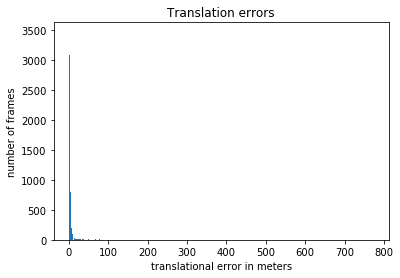

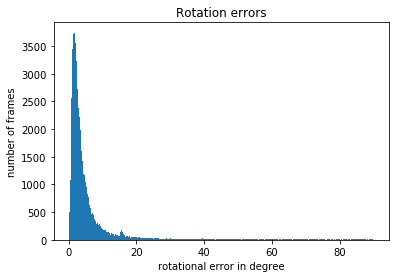

median translation error = 2.015
median rotation error = 2.879
mean translation error = 10.630
mean rotation error = 6.214


In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(trans_errors, bins='auto')
plt.title("Translation errors")
plt.xlabel("translational error in meters")
plt.ylabel("number of frames")
#plt.savefig('terror.png', bbox_inches='tight')
plt.show()

plt.hist(rot_errors, bins='auto')
plt.title("Rotation errors")
plt.xlabel("rotational error in degree")
plt.ylabel("number of frames")
#plt.savefig('rerror.png', bbox_inches='tight')
plt.show()

median_trans_errors = np.median(trans_errors)
median_rot_errors = np.median(rot_errors)
mean_trans_errors = np.mean(trans_errors)
mean_rot_errors = np.mean(rot_errors)

print("median translation error = {:.3f}".format(median_trans_errors))
print("median rotation error = {:.3f}".format(median_rot_errors))
print("mean translation error = {:.3f}".format(mean_trans_errors))
print("mean rotation error = {:.3f}".format(mean_rot_errors))   

In [8]:
def evaluate(trans_errors,rot_errors):
    t = test_dataset.last_indexes
    trans_errors_month = list()
    trans_errors_month.append(trans_errors[:t[0]])
    trans_errors_month.append(trans_errors[t[0]:t[1]])
    trans_errors_month.append(trans_errors[t[1]:t[2]])
    trans_errors_month.append(trans_errors[t[2]:t[3]])
    trans_errors_month.append(trans_errors[t[3]:t[4]])
    trans_errors_month.append(trans_errors[t[4]:t[5]])
    trans_errors_month.append(trans_errors[t[5]:t[6]])
    trans_errors_month.append(trans_errors[t[6]:])

    rot_errors_month = list()
    rot_errors_month.append(rot_errors[:t[0]])
    rot_errors_month.append(rot_errors[t[0]:t[1]])
    rot_errors_month.append(rot_errors[t[1]:t[2]])
    rot_errors_month.append(rot_errors[t[2]:t[3]])
    rot_errors_month.append(rot_errors[t[3]:t[4]])
    rot_errors_month.append(rot_errors[t[4]:t[5]])
    rot_errors_month.append(rot_errors[t[5]:t[6]])
    rot_errors_month.append(rot_errors[t[6]:])
    
    print('================== median translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("median translation error = {:.3f}".format(np.median(trans_errors_i)))
        
    print('================== median rotation error ==================')
    for rot_errors_i in rot_errors_month:
        print("median rotation error = {:.3f}".format(np.median(rot_errors_i)))
    
    print('================== mean translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("mean translation error = {:.3f}".format(np.mean(trans_errors_i)))
        
    print('================== mean rotation error ==================')  
    for rot_errors_i in rot_errors_month:
        print("mean rotation error = {:.3f}".format(np.mean(rot_errors_i)))
        
evaluate(trans_errors,rot_errors)

================== median translation error ==================
median translation error = 1.558
median translation error = 1.630
median translation error = 1.909
median translation error = 1.881
median translation error = 1.981
median translation error = 2.054
median translation error = 3.392
median translation error = 2.737
================== median rotation error ==================
median rotation error = 2.476
median rotation error = 2.557
median rotation error = 2.677
median rotation error = 2.630
median rotation error = 2.866
median rotation error = 2.933
median rotation error = 4.056
median rotation error = 4.019
================== mean translation error ==================
mean translation error = 4.041
mean translation error = 4.349
mean translation error = 12.481
mean translation error = 12.354
mean translation error = 9.446
mean translation error = 11.265
mean translation error = 20.090
mean translation error = 13.570
================== mean rotation error ==================
m